In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [3]:
import os

In [4]:
import random

In [5]:
import pandas as pd

In [6]:
from torch.utils.tensorboard import SummaryWriter

In [50]:
from exp import nb_loss_metrics
from exp import nb_databunch
from exp import nb_resnet_unet
from exp import nb_train_eval

In [8]:
import numpy as np

In [9]:
# export
import torch

In [10]:
# export
from torch import tensor

In [11]:
from fastai.basic_train import Learner

In [12]:
# export
from matplotlib import pyplot as plt

In [13]:
# export
from matplotlib import patches,patheffects

In [14]:
# export
from IPython.core import debugger as idb

In [15]:
from fastai.vision.image import Image

In [16]:
from fastai.vision import *

In [17]:
from functools import partial

In [18]:
# export
from math import ceil

In [19]:
import cv2

In [20]:
import PIL

# functions

In [21]:
class Normalizer():
    def __init__(self,mean,std,device):
        self.mean = mean.to(device)
        self.std = std.to(device)
        
    def __call__(self,x):
        res = x/255
        res = (res-self.mean)/self.std
        return res

In [22]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [26]:
device = torch.device('cuda', 0)

In [27]:
# 提取与输入输出处理有关的参数
#normMean = state['data']['normalize']['mean']
#normStd = state['data']['normalize']['std']
normMean = Tensor(imagenet_stats[0])
normStd = Tensor(imagenet_stats[1])

In [28]:
# 输入图片需要经normalize才能给到模型输入，这是做normalize的函数
normalize = Normalizer(mean=normMean[None,:,None,None],
                       std=normStd[None,:,None,None],
                       device=device)

In [29]:
def pred(model, rimgs):
    #把图片放到网络里面去
    timgs = []
    for simg in rimgs:
        timgs += [tensor(simg.transpose(2,0,1)).unsqueeze(0)]
    timgs = torch.cat(timgs,0)
    print(timgs.shape)
    netin = normalize(timgs.float().to(device))
    #data_200.normalize
    with torch.no_grad():
        netouts = model(netin)
    out = netouts.sigmoid()
    return out

In [30]:
def show_preds(out, rimgs):
    assert len(out) == len(rimgs)
    fig, axs = plt.subplots(len(rimgs), 2, figsize=(8 * 2, 8 * len(rimgs)))
    for i in range(len(rimgs)):
        axs[i, 0].imshow(np.squeeze(out[i].cpu().numpy()))
    for i in range(len(rimgs)):
        axs[i, 1].imshow(rimgs[i]) 

# test

## 准备好learner

In [55]:
device = torch.device('cuda', 0)

In [56]:
#用200数据集的训练结果进行测试。但是用的测试的数据集是200的
data_200 = nb_databunch.get_databunch('./data/dataset_20200715',bs=4,device=device, transforms = None) 

In [57]:
tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset2000','adam'])
getlearn = partial(nb_train_eval.get_learn, data = data_200, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = True, tag = tag)

In [58]:
learn = getlearn()

In [59]:
pthfn = os.path.join('train_logs/', tag, 'run_0.pth')

In [60]:
pthfn

'train_logs/resnet18__allres__dice_loss__dataset2000__adam/run_0.pth'

In [61]:
with open(pthfn,'rb') as f:
    learn.load(f)

In [62]:
tmp = torch.load(pthfn)

In [64]:
# 把模型放到device上，如果使用GPU，则设置使用哪几个GPU
if hasattr(learn.model, "module"): 
    learn.model = learn.model.module

learn.model.to(device);

if device.type=='cuda':
    learn.model = torch.nn.DataParallel(learn.model,device_ids=[0])

In [65]:
learn.model.eval();

## 观察

In [ ]:
x, y = next(iter(data_200.valid_dl))

In [ ]:
with torch.no_grad():
    out = learn.model(x)

In [32]:
out = out.sigmoid()

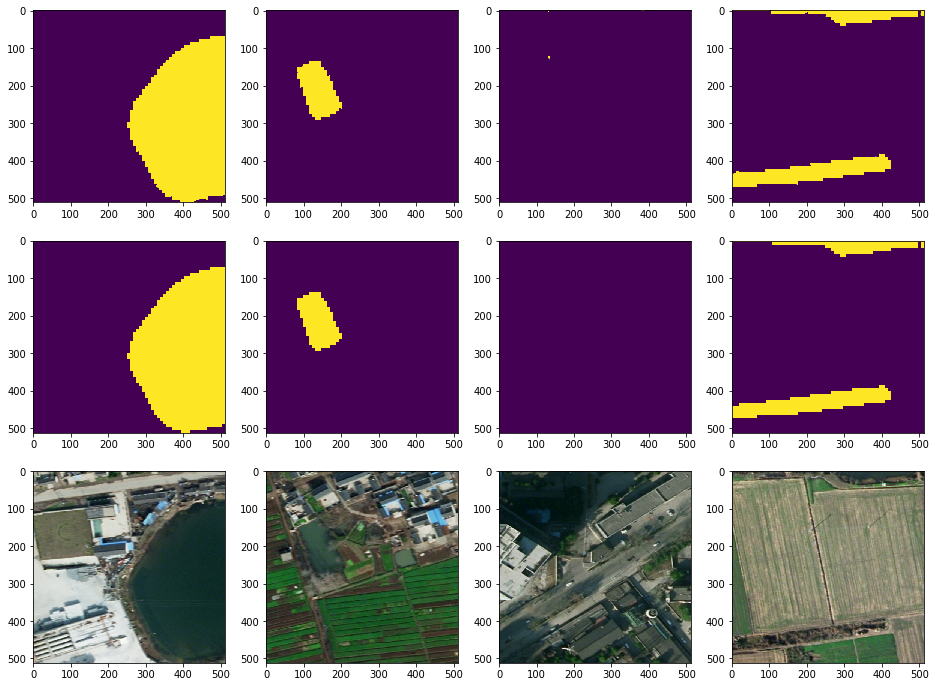

In [33]:
#看看结果和验证集差异。第一行是输出记过，第二行是验证集
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
for i in range(4):
    axs[0, i].imshow(np.squeeze(out[i].cpu().numpy()))
for i in range(4):    
    axs[1, i].imshow(np.squeeze(y[i].cpu().numpy()))
dx = data_200.denorm(x)
for i in range(4):
    axs[2, i].imshow(dx[i].permute(1,2,0))    

## 看看在数据集外的图像上的表现

In [66]:
SZ = 512

In [67]:
mask = cv2.imread('data/label/4masks.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
#mask = PIL.Image.open('data/label/4masks.png')

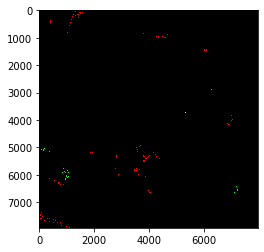

In [68]:
#红色是水体。绿色的是操场。简单标出大概的位置
mark = np.array([255], dtype=np.uint8)
plt.imshow((mask == mark).astype(np.uint8) * 255)

(7939, 7969)


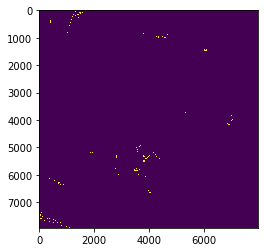

In [69]:
t = (mask == mark[0]).astype(np.uint8) * 255
print(t[:,:,0].shape)
plt.imshow(t[:,:,0])

In [70]:
img = cv2.imread('data/src/image/4.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

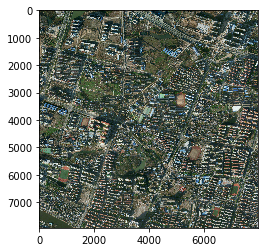

In [71]:
plt.imshow(img)

In [109]:
cnt = 0

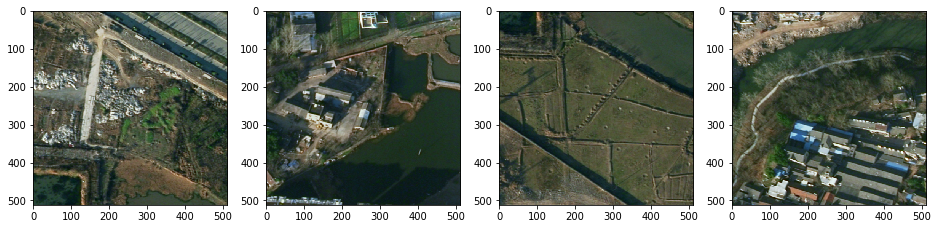

In [126]:
#提取四个图片出来。要求必须包含水体。
rimgs = []
h, w, _ = img.shape
watermask = ((mask == mark[0]).astype(np.uint8) * 255)[:,:,0]
while True:
    x = random.randint(0, w - SZ - 1)
    y = random.randint(0, h - SZ - 1)
    simg = img[y : y + SZ, x : x + SZ]
    smask = watermask[y : y + SZ, x : x + SZ]
    #print(smask.sum() // 255, smask.shape)
    #print(smask.data)
    
    
    #print(simg.shape)
    if smask.sum() // 255 > 1500:#不区分是水还是操场
        #plt.imshow(simg)
        rimgs += [simg]
    
        cv2.imwrite('%03d.png' % cnt, simg)
        #cv2.imwrite('%02d_mask.png' % cnt, smask)    
        cnt += 1
        
    if len(rimgs) == 4:
        break

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axs[i].imshow(rimgs[i])
    

In [127]:
out = pred(learn.model, rimgs)

torch.Size([4, 3, 512, 512])


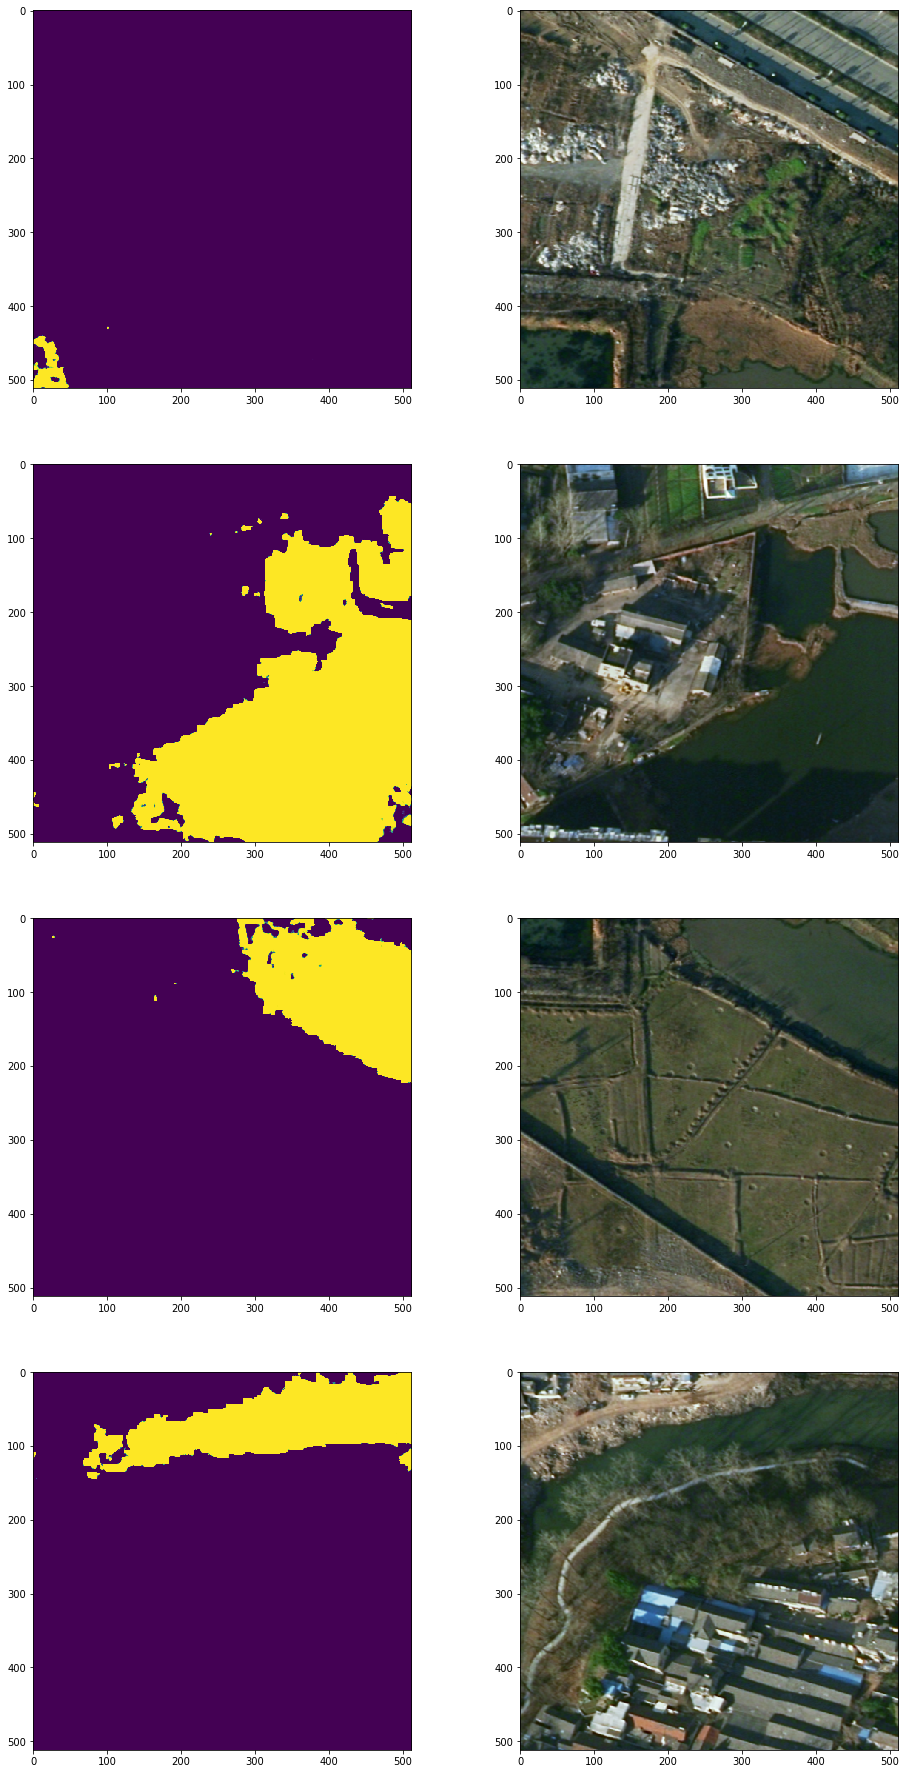

In [128]:
show_preds(out, rimgs)

### 统计0、1以为值的比例

In [188]:
npout = out.cpu().numpy()

In [190]:
npout.flatten().shape

(1048576,)

In [199]:
npout = (npout * 100).astype(int)

In [201]:
npout = npout.flatten()

In [202]:
np.unique(npout)

array([  0,   1,   2,   3, ...,  97,  98,  99, 100])

In [203]:
np.unique(npout).shape

(101,)

In [204]:
cnt = [np.sum(npout == i) for i in range(101)]

<BarContainer object of 101 artists>

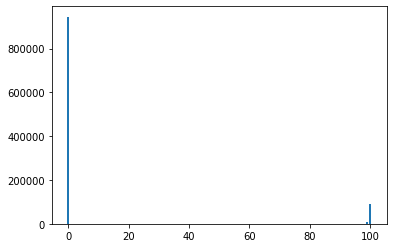

In [207]:
plt.bar(range(101), cnt)

## 再看看另一个训练结果

In [63]:
tag2 = '__'.join(['resnet18', 'vanila', 'dice_loss', 'dataset200','adam'])
getlearn2 = partial(nb_train_eval.get_learn, data = data_200, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = False, tag = tag2)

In [35]:
pthfn2 = os.path.join('train_logs/', tag2, 'run_0.pth')

In [64]:
pathfn2 = 'data/dataset_20200715_200_et/image/models/run_0.pth'

In [65]:
learn2 = getlearn2(tag = tag2)

In [66]:
with open(pthfn2,'rb') as f:
    learn2.load(f)
# 把模型放到device上，如果使用GPU，则设置使用哪几个GPU
if hasattr(learn2.model, "module"): 
    learn2.model = learn2.model.module

learn2.model.to(device);

if device.type=='cuda':
    learn2.model = torch.nn.DataParallel(learn2.model,device_ids=[5])    
learn2.model.eval();    

torch.Size([4, 3, 512, 512])


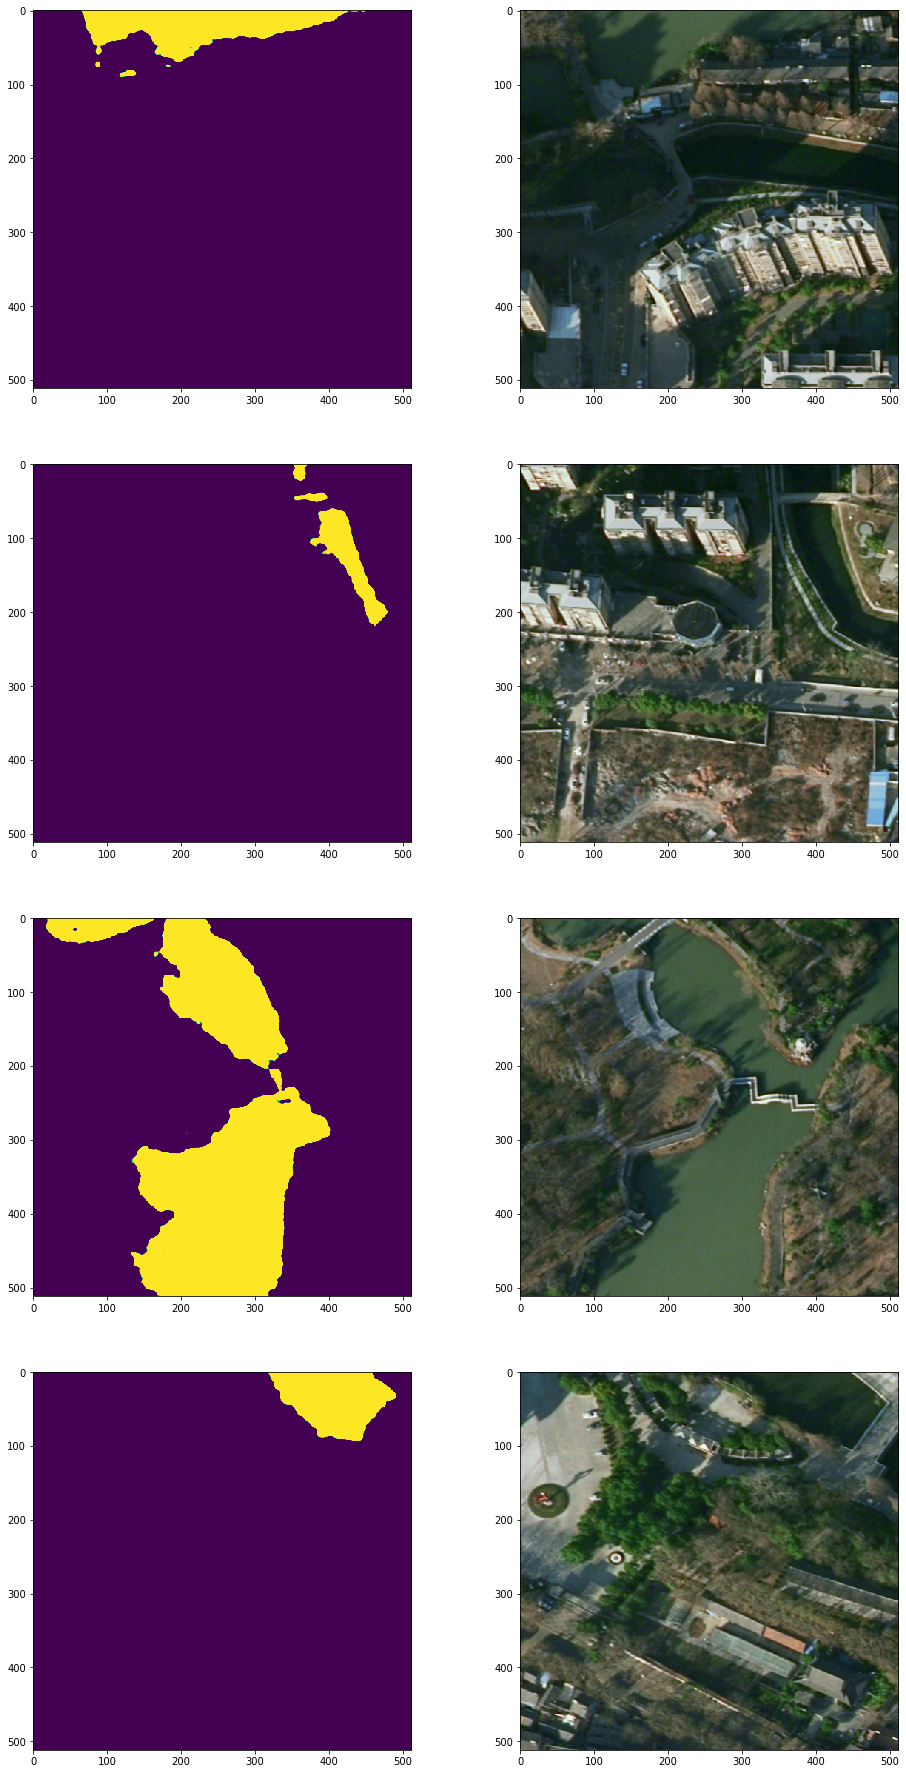

In [67]:
out2 = pred(learn2.model, rimgs)
show_preds(out2, rimgs)

## 训练曲线

train_logs/resnet18__vanila__dice__dataset200__adam__NaN__test_0/csv_log run_0.csv
train_logs/resnet18__vanila__dice__dataset200__adam__NaN__test_1/csv_log run_0.csv
train_logs/resnet18__vanila__dice__dataset200__adam__NaN__test_2/csv_log run_0.csv
train_logs/resnet18__vanila__dice__dataset200__adam__NaN__test_3/csv_log run_0.csv
train_logs/resnet18__vanila__dice__dataset200__adam__NaN__test_4/csv_log run_0.csv
train_logs/resnet18__vanila__dice__dataset200__adam__NaN__test_5/csv_log run_0.csv
train_logs/resnet18__vanila__dice__dataset200__adam__NaN__test_6/csv_log run_0.csv
train_logs/resnet18__vanila__dice__dataset200__adam__NaN__test_7/csv_log run_0.csv
test_0
test_1
test_2
test_3
test_4
test_5
test_6
test_7


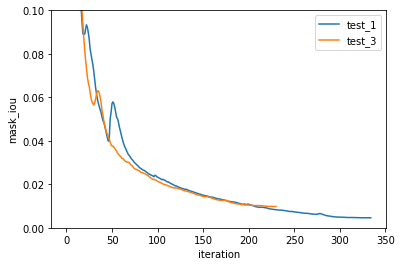

In [147]:
#for i in os.scandir('train_logs'):
dfs = []
for i in os.walk('train_logs'):
    #print(i)
    if i[0].find('test') < 0:#跳过
        continue
    for f in i[2]:
        if f == 'run_0.csv':
            print(i[0], f)
            df = pd.read_csv(os.path.join(i[0], f))
            dfs += [(df, i[0].split('/')[-2].split('__')[-1])]
for df, lbl in dfs:    
    print(lbl)
    #plt.plot(df.mask_iou, label = lbl)
    if lbl in ['test_1', 'test_3']:
        plt.plot(df.train_loss, label = lbl)

plt.ylim((0.,0.1))    
plt.xlabel('iteration')    
plt.ylabel('mask_iou')

plt.legend()
plt.show()            
#df            
    

# export

In [ ]:
!python notebook2script.py --fname 'interpretation.ipynb' --outputDir './exp/'